In [1]:
import pandas as pd
import numpy as np

train = pd.read_json('train.json')
test = pd.read_json('test.json')

In [8]:
train_band1 = np.array([np.array(band) for band in train['band_1']])
train_band2 = np.array([np.array(band) for band in train['band_2']])
test_band1 = np.array([np.array(band) for band in test['band_1']])
test_band2 = np.array([np.array(band) for band in test['band_2']])
print(train_band1.shape, train_band2.shape, test_band1.shape, test_band2.shape)

(1604, 5625) (1604, 5625) (8424, 5625) (8424, 5625)


In [20]:
train_band1 = train_band1.reshape((-1, 75, 75))
flip1 = np.flip(train_band1, 1)
flip2 = np.flip(train_band1, 2)
train_band1 = np.concatenate([train_band1, flip1, flip2], axis=0)
train_band1 = train_band1.reshape(-1, 5625)
train_band2 = train_band2.reshape((-1, 75, 75))
flip1 = np.flip(train_band2, 1)
flip2 = np.flip(train_band2, 2)
train_band2 = np.concatenate([train_band2, flip1, flip2], axis=0)
train_band2 = train_band2.reshape((-1, 5625))
print(train_band1.shape, train_band2.shape)

(4812, 5625) (4812, 5625)


In [21]:
all_band1 = np.concatenate([train_band1, test_band1], axis = 0)
all_band2 = np.concatenate([train_band2, test_band2], axis = 0)
print(all_band1.shape, all_band2.shape)

(13236, 5625) (13236, 5625)


In [22]:
from sklearn.decomposition import PCA

decomp1 = PCA(n_components=0.95)
decomp2 = PCA(n_components=0.95)

new_band1 = decomp1.fit_transform(all_band1)
new_band2 = decomp2.fit_transform(all_band2)

print(new_band1.shape, new_band2.shape)

(13236, 1730) (13236, 2385)


In [24]:
X_train = np.concatenate([new_band1[:4812], new_band2[:4812]], axis=1)
test = np.concatenate([new_band1[4812:], new_band2[4812:]], axis=1)
Y_train = train['is_iceberg']
Y_train = np.concatenate([Y_train, Y_train, Y_train], axis = 0)
print(X_train.shape, Y_train.shape, test.shape)

(4812, 4115) (4812,) (8424, 4115)


In [26]:
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

classifiers = [XGBClassifier(), LGBMClassifier(), SVC(probability=True), \
               KNeighborsClassifier()]

kf = KFold(n_splits=5, random_state=0)

log_cols = ['Classifier', 'log_loss']
log = pd.DataFrame(columns=log_cols)

acc_dict = {}
for (train_index, cv_index) in kf.split(X_train, Y_train):
    X_tr = X_train[train_index]
    Y_tr = Y_train[train_index]
    X_cv = X_train[cv_index]
    Y_cv = Y_train[cv_index]
    
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_tr, Y_tr)
        predict = clf.predict_proba(X_cv)
        acc = log_loss(Y_cv, predict)
        print(name, acc)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc
            
for clf in acc_dict:
    acc_dict[clf] /= 5
    entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(entry)
    

XGBClassifier 0.452211773862
LGBMClassifier 0.535863098278
SVC 0.697619246752
KNeighborsClassifier 1.43601026013
XGBClassifier 0.445853064304
LGBMClassifier 0.535871388889
SVC 0.688999841943
KNeighborsClassifier 1.08428755641
XGBClassifier 0.448561505517
LGBMClassifier 0.543388383574
SVC 0.69566829138
KNeighborsClassifier 1.70870523618
XGBClassifier 0.443930600651
LGBMClassifier 0.534006451045
SVC 0.689967708016
KNeighborsClassifier 1.40607736667
XGBClassifier 0.476543823595
LGBMClassifier 0.551620351452
SVC 0.688586087825
KNeighborsClassifier 2.11452434365


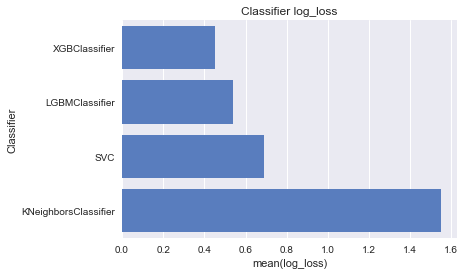

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.xlabel('log_loss')
plt.title('Classifier log_loss')

sns.set_color_codes("muted")
sns.barplot(x='log_loss', y='Classifier', data=log, color="b")

In [17]:
log.head(7)

,Classifier,RMSE
0,DecisionTreeClassifier,11.778489
0,RandomForestClassifier,0.676312
0,AdaBoostClassifier,0.672589
0,GradientBoostingClassifier,0.478394
0,XGBClassifier,0.477159
0,LGBMClassifier,0.544782
0,KNeighborsClassifier,1.742533
